<a href="https://colab.research.google.com/github/RidhaLOUZE/VIT_in_pytorch_deit_2041/blob/main/vision_transformers_in_pytorch_deit_2041_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roufaidahammadou","key":"2cf4ca6acd958e5206bba448f19eb3b6"}'}

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
print("deneme")

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ciplab/real-and-fake-face-detection

 95% 409M/431M [00:01<00:00, 258MB/s]
100% 431M/431M [00:01<00:00, 279MB/s]


In [ ]:
! mkdir 2041

In [ ]:
! unzip /content/real-and-fake-face-detection.zip -d 2041

Archive:  /content/real-and-fake-face-detection.zip
  inflating: 2041/real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_106_0011.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_107_1011.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_108_1111.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_109_1111.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_10_0001.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_110_0001.jpg  
  inflating: 2041/real_and_fake_face/training_fake/easy_111_1101.jpg  
  inflating: 2041/real_and

In [ ]:
import glob
import shutil
import os

print(len(os.listdir("/content/2041/real_and_fake_face/training_fake")))
print(len(os.listdir("/content/2041/real_and_fake_face/training_real")))
print(len(os.listdir("/content/2041/real_and_fake_face/training_fake")))
print(len(os.listdir("/content/2041/real_and_fake_face/training_real")))
#im = os.listdir("/content/140k/real_vs_fake/real-vs-fake/train/real/00010.jpg")
#print(im.shape)

960
1081
960
1081


In [ ]:
! pip install split-folders

import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install split-folders

import splitfolders
input_folder = '/content/2041/real_and_fake_face/'
splitfolders.ratio(input_folder, output="/content/split_real-and-fake-detection", 
                   seed=42, ratio=(.8, .1,.1), 
                   group_prefix=None) # default values


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 2041 files [00:00, 3429.63 files/s]


In [ ]:
import os
print(len(os.listdir("/content/split_real-and-fake-detection/valid/training_fake")))
print(len(os.listdir("/content/split_real-and-fake-detection/valid/training_real")))

print(len(os.listdir("/content/split_real-and-fake-detection/valid/training_fake")))
print(len(os.listdir("/content/split_real-and-fake-detection/valid/training_real")))

96
108
96
108


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# We use a butterfly dataset of 50 species to demonstrate the classification method

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [ ]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 10.8 MB/s 


In [ ]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import sys
from tqdm import tqdm
import time
import copy

In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [ ]:
dataset_path = "/content/split_real-and-fake-detection"

In [ ]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [ ]:
classes = get_classes("/content/split_real-and-fake-detection/train/")
print(classes, len(classes))

['training_fake', 'training_real'] 2


In [ ]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [ ]:
print(len(train_loader), len(val_loader), len(test_loader))

51 7 7


In [ ]:
print(train_data_len, valid_data_len, test_data_len)

1632 204 205


In [ ]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth


  0%|          | 0.00/21.9M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), ep

In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [ ]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.97)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler) # now it is a lot faster
# I will come back after 10 epochs

Epoch 0/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


train Loss: 0.7216 Acc: 0.5276


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


val Loss: 0.6844 Acc: 0.5490

Epoch 1/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.66it/s]


train Loss: 0.6693 Acc: 0.6048


100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


val Loss: 0.7053 Acc: 0.5392

Epoch 2/19
----------


100%|██████████| 51/51 [00:24<00:00,  2.12it/s]


train Loss: 0.6385 Acc: 0.6556


100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


val Loss: 0.6915 Acc: 0.5931

Epoch 3/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


train Loss: 0.6434 Acc: 0.6330


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


val Loss: 0.7167 Acc: 0.5637

Epoch 4/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.63it/s]


train Loss: 0.6200 Acc: 0.6801


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


val Loss: 0.7165 Acc: 0.5294

Epoch 5/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


train Loss: 0.6030 Acc: 0.6918


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


val Loss: 0.7219 Acc: 0.5588

Epoch 6/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


train Loss: 0.5886 Acc: 0.7047


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


val Loss: 0.7465 Acc: 0.5441

Epoch 7/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


train Loss: 0.5763 Acc: 0.7138


100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


val Loss: 0.7477 Acc: 0.5931

Epoch 8/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


train Loss: 0.5579 Acc: 0.7279


100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


val Loss: 0.7276 Acc: 0.5931

Epoch 9/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.58it/s]


train Loss: 0.5480 Acc: 0.7512


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


val Loss: 0.7276 Acc: 0.6127

Epoch 10/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


train Loss: 0.5313 Acc: 0.7659


100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


val Loss: 0.7529 Acc: 0.5490

Epoch 11/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


train Loss: 0.5167 Acc: 0.7812


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


val Loss: 0.7737 Acc: 0.5784

Epoch 12/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


train Loss: 0.5069 Acc: 0.7782


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


val Loss: 0.7762 Acc: 0.5980

Epoch 13/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.64it/s]


train Loss: 0.4891 Acc: 0.8058


100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


val Loss: 0.7401 Acc: 0.5980

Epoch 14/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


train Loss: 0.4790 Acc: 0.7972


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


val Loss: 0.7521 Acc: 0.5882

Epoch 15/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


train Loss: 0.4653 Acc: 0.8223


100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


val Loss: 0.7907 Acc: 0.5735

Epoch 16/19
----------


100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


train Loss: 0.4545 Acc: 0.8266


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


val Loss: 0.7897 Acc: 0.5686

Epoch 17/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train Loss: 0.4426 Acc: 0.8487


100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


val Loss: 0.8043 Acc: 0.5588

Epoch 18/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


train Loss: 0.4411 Acc: 0.8505


100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


val Loss: 0.8250 Acc: 0.5931

Epoch 19/19
----------


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train Loss: 0.4389 Acc: 0.8456


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


val Loss: 0.8511 Acc: 0.5980

Training complete in 7m 31s
Best Val Acc: 0.6127


## Testing

Ok, now we finished training. Lets run the dataset on the test loader and calculate accuracy

In [ ]:
# anyways, we can use model, for it is also updated witht he latest weights

In [ ]:
# our model earns 93% test accuracy, which is very high. lets save it
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("/content/drive/MyDrive/projects/H5/VIT_2041.h5")

In [ ]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    #data, target = data.cuda(), target.cuda()
    data, target = data.to(device), target.to(device)
   
    if torch.cuda.is_available():
      model.cuda()

    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

Test Loss: 0.0330
Test Accuracy of training_fake: 44% (41/93)
Test Accuracy of training_real: 57% (57/99)
Test Accuracy of 51% (98/192)


In [ ]:
print(len(acc))

21


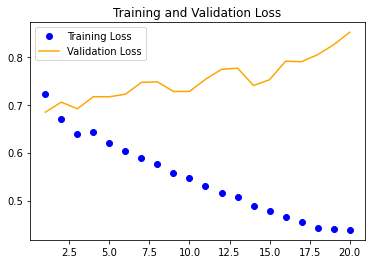

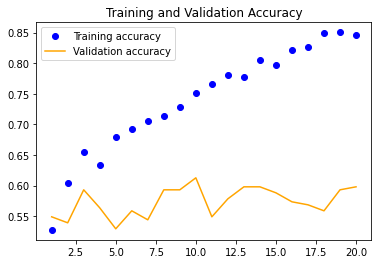

In [ ]:
import matplotlib.pyplot as plt
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
loss = [0.7216,0.6693,0.6385,0.6434,0.6200,0.6030,0.5886,0.5763,0.5579,0.5480,0.5313,0.5167,0.5069, 0.4891,0.4790,0.4653,0.4545, 0.4426,0.4411, 0.4389]
acc = [ 0.5276,0.6048,0.6556,0.6330,0.6801,0.6918,0.7047,0.7138,0.7279,0.7512,0.7659,0.7812,0.7782,0.8058,0.7972,0.8223,0.8266,0.8487,0.8505,0.8456]
val_loss = [0.6844,0.7053,0.6915,0.7167,0.7165,0.7219,0.7465,0.7477,0.7276,0.7276,0.7529, 0.7737,0.7762,0.7401,0.7521,0.7907,0.7897,0.8043,0.8250,0.8511]
val_acc = [0.5490,0.5392,0.5931,0.5637,0.5294, 0.5588, 0.5441,0.5931,0.5931,0.6127, 0.5490,0.5784,0.5980,0.5980,0.5882,0.5735,0.5686, 0.5588, 0.5931,0.5980]

def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)